# Ex 1 - SAR Datacube

In this example, we will create datacube using a stack of Ground Range Detected (GRD) images and Single Look Complex (SLC) images. 

The aim of the example is to show how to create datacubes from raster (GRD/SLC) directory, read the generated datacubes as a `SARDatacube` object, display the array, run some simple metadata queries, and then save the datacube in netCDF format.

ICEcube works with two different data types:

 - The GRD - Ground Range Detected images are georegistered rasters. ICEYE uses the .tif format. This image has only signal intensity and not the complex information.

- SLC - The Single Look Complex files from ICEYE are in the.hdf5 format, the SLC products preserve the phase information.

In [5]:
import os,sys,inspect
import numpy as np
from os.path import dirname, abspath, join
import icecube
from icecube.bin.sar_cube.grd_datacube import GRDDatacube
from icecube.bin.sar_cube.slc_datacube import SLCDatacube
from icecube.bin.config import CubeConfig 
import matplotlib.pyplot as plt
from pathlib import Path 
from icecube.bin.datacube_variables import NAME_INTENSITY_BAND

## Creating  a Datacube from GRDs

Modify the following paths based on your use case. For the purpose of this demo, we'll work on a subset of images used for testing the library.

In [6]:
icecube_abspath = str(Path(icecube.__file__).parent.parent)
test_dir_grds = os.path.join(icecube_abspath, "tests/resources/grd_stack")
test_dir_slcs = os.path.join(icecube_abspath, "tests/resources/slc_stack")
print(f"The GRDs used for the demo are located at local_path/icecube/tests/resources/")

The GRDs used for the demo are located at local_path/icecube/tests/resources/


The first step is to create or edit the config file, which is a json file containing the parameters that you want to modify for the datacube construction.

### Config

Configuring datacubes by a .json file provides a convenient way for the user to build datacubes from a monolithic directory of SAR images without worrying about the manual selection of SAR data. You can dump all SAR images into a common directory and slice the information per your need by specifying the date range. Seasonality effects with the datacubes can also be analyzed by slicing information for the required dates.  Be it an event of interest of a short time period or repeated nature, you can configure the datacubes to suit your application needs.

The following is a brief description of the parameters that can be passed to configure datacubes:

- `start_date`: The date from which the SAR images will be considered for the stack (format: int/str %Y%M%D)
- `end_date`: The last date of the image stack (format: int/str %Y%M%D)
- `min_incidence_angle`: The lowest incidence angle in the image stack (format: float/int)
- `max_incidence_angle`:  The highest incidence angle in the image stack (format: float/int)
- `temporal_resolution`: The observation interval (number of days) to be considered between the images in the stack (format: float/int)
- `temporal_overlap`: To decide whether images with the same date should be considered (format: bool/int)

If the default user configuration is used, all images inside the directory are considered for building the datacubes and no pruning on dates or incidence angles is performed. 

In [7]:
cube_config = CubeConfig()

# If you want to load config parameters;
#cube_config.load_config(cube_config_path)

# Example json:
#{
#    "start_date": "20200402",
#    "end_date": "20210420",
#    "min_incidence_angle": 20,
#    "max_incidence_angle": 21,
#    "temporal_resolution": 1,
#    "coregistered": true,
#    "space_overlap": true,
#    "temporal_overlap": true
#}

In [8]:
# build the datacube composed by a stack of GRD

# The program will execute the following steps:
#  - Fetch the metadata of the images
#  - Build a dataframe containing the metadata
#  - Apply the filtering (sort by date, select by angle)
#  - From the filtered metadata, it will load the data accordingly 

grd_datacube = GRDDatacube.build(cube_config, test_dir_grds)

09/07/2021 04:07:10 PM - sar_datacube_metadata.py - [INFO] - Building the metadata from the folder /mnt/xor/ICEYE_PACKAGES/icecube/tests/resources/grd_stack using GRD
processing rasters for cubes: 100%|██████████| 3/3 [00:00<00:00, 182.52it/s]
09/07/2021 04:07:10 PM - common_utils.py - [INFO] - create running time is 0.0331 seconds


### `GRDDatacube` object

Every `GRDDatacube` object is a `SARDatacube`

These have multiple methods:

- `.cube_config` -> As seen above, the configuration is the one used to create the datacube. We can modify those parameters by defining a json file that will overload every parameters. 


- `.xrdataset` -> This is theXarray.Dataset containing the stack of images, (Azimuth, Range and Band). Each image is loaded using dask (for memory optimization) and then tranformed into an Xarray.Dataarray. There is one temporal layer in the datacube for each GRD file found in your directory.


- `.get_metadata(temporal_index)` ->  Returns the metadata of the image at the certain index, this is Dict[str, str] representing the images

In [9]:
# You can access the dataset, for an easy visualization. The 'Band' dimension shows the number of GRD images stacked from your input path.
grd_datacube.xrdataset.head

<bound method Dataset.head of <xarray.Dataset>
Dimensions:    (Azimuth: 10, Band: 3, Range: 10)
Coordinates:
  * Azimuth    (Azimuth) int64 0 1 2 3 4 5 6 7 8 9
  * Range      (Range) int64 0 1 2 3 4 5 6 7 8 9
  * Band       (Band) datetime64[ns] 2021-04-27 2021-04-28 2021-05-27
Data variables:
    Intensity  (Band, Azimuth, Range) uint16 329 389 217 418 ... 597 85 482 334>

In [10]:
# Access the array dimensions
grd_datacube.xrdataset.dims

Frozen(SortedKeysDict({'Azimuth': 10, 'Range': 10, 'Band': 3}))

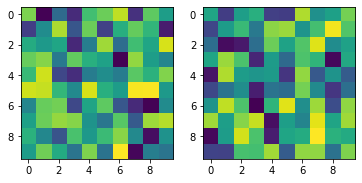

In [11]:
# Let's visualize the intensity component of the grd_datacube for the first and last image of the stack. 
# Will convert the data to bytes (from float64), so we can see something.

fig, ax = plt.subplots(1,2)

#First image in the stack
ax[0].imshow(np.byte(grd_datacube.xrdataset['Intensity'][0].values))

#Last image in the stack
ax[1].imshow(np.byte(grd_datacube.xrdataset['Intensity'][-1].values))

In [12]:
# Slice the stack at the pixel level. If the GRD stack are co-located images at different times, you are slicing by time at this point:
# Let's pick the first pixel in range and aziumuth for all images in the stack. 

#Check the shape of the stack again
print(grd_datacube.xrdataset['Intensity'].shape)

#the stack depth is the first dimension of the array
pixel_time_series = grd_datacube.xrdataset['Intensity'][:,1,1].values
print(f"The time series for the pixel located to the pixel (1,1) is {pixel_time_series}")

(3, 10, 10)
The time series for the pixel located to the pixel (1,1) is [508  81 525]


The raw ICEYE image metadata for each image can be accessed using the method `get_metadata(attributes, datavars, cube_index)`or directly using attrs of the xarray.Dataset[data_vars]


grd_datacube.xrdataset["intensity"].attrs will return a dict[str, list]

- `key` represents the metadata key
- `vlues` represents the values associated with each layer of the datacube - a missing value is represented by `None`

In [13]:
# visualize all possibles values
grd_datacube.xrdataset['Intensity'].attrs.keys()

dict_keys(['azimuth_time_interval', 'ant_elev_corr_flag', 'product_file', 'tropo_range_delay', 'incidence_angle_ground_range_origin', 'number_of_dc_estimations', 'chirp_duration', 'velY', 'orbit_absolute_number', 'posY', 'orbit_direction', 'calibration_factor', 'incidence_angle_poly_order', 'total_processed_bandwidth_azimuth', 'gcp_terrain_model', 'acquisition_mode', 'range_looks', 'incidence_near', 'coord_center', 'acquisition_end_utc', 'spec_version', 'state_vector_time_utc', 'posX', 'heading', 'number_of_range_samples', 'product_level', 'mean_orbit_altitude', 'grsr_coefficients', 'acquisition_prf', 'grsr_poly_order', 'azimuth_looks', 'azimuth_look_overlap', 'product_name', 'range_look_bandwidth', 'look_side', 'azimuth_spacing', 'satellite_look_angle', 'incidence_center', 'geo_ref_system', 'carrier_frequency', 'sample_precision', 'coord_last_near', 'doppler_rate_poly_order', 'range_sampling_rate', 'number_of_azimuth_samples', 'orbit_relative_number', 'coord_first_far', 'velX', 'polar

In [14]:
# You can see the list of values a specific metadata
grd_datacube.xrdataset['Intensity'].attrs['product_file']

['ICEYE_GRD_54549_20210427T215124_hollow_10x10pixels_fake_1.tif',
 'ICEYE_GRD_54549_20210427T215124_hollow_10x10pixels_fake_0.tif',
 'ICEYE_GRD_54549_20210427T215124_hollow_10x10pixels_fake_2.tif']

In [15]:
# If you know what you are looking for, you can directly use the`get_metadata(attr, var, index)` method
grd_datacube.get_metadata("product_file", 'Intensity', 0)

'ICEYE_GRD_54549_20210427T215124_hollow_10x10pixels_fake_1.tif'

## Creating  a Datacube from SLCs

Following the same logic - you can create a stack from the SLCs images - `SLCDatacube` will return a `SARDatacube` that means that you have access to the same functionalities using either SLCs or GRDs as input

### `SLCDatacube` object

Every `SLCDatacube` object is a `SARDatacube`

You can access the data, using the `xrdataset` attribute:

- `.xrdataset` -> This is theXarray.Dataset containing the stack of images, (Azimuth, Range and temporal dimension). Each image is loaded using dask (for memory optimization) and then tranformed into an Xarray.DataArray. There is one temporal layer in the datacube for each SLC file found in your directory.

In [16]:
slc_datacube = SLCDatacube.build(cube_config, test_dir_slcs)

09/07/2021 04:07:10 PM - sar_datacube_metadata.py - [INFO] - Building the metadata from the folder /mnt/xor/ICEYE_PACKAGES/icecube/tests/resources/slc_stack using SLC
processing rasters for cubes: 100%|██████████| 3/3 [00:00<00:00, 29.13it/s]
09/07/2021 04:07:10 PM - common_utils.py - [INFO] - create running time is 0.1878 seconds


Each image pixel is represented by a complex (I and Q) magnitude value and therefore contains both amplitude and phase information.  The processing for all SLC products results in a single look in each dimension using the full available signal bandwidth. The imagery is geo-referenced using orbit and attitude data from the satellite. SLC images are produced in a zero Doppler geometry. This convention is common with the standard slant range products available from other SAR sensors.

Creating the datacube using SLCs will result with 2 bands, `Real` and `Complex` information.

In [17]:
slc_datacube.xrdataset.head()

<xarray.Dataset>
Dimensions:  (Azimuth: 5, Band: 3, Range: 5)
Coordinates:
  * Azimuth  (Azimuth) int64 0 1 2 3 4
  * Range    (Range) int64 0 1 2 3 4
  * Band     (Band) datetime64[ns] 2021-04-27 2021-04-28 2021-05-27
Data variables:
    Real     (Band, Azimuth, Range) float32 dask.array<chunksize=(1, 5, 5), meta=np.ndarray>
    Complex  (Band, Azimuth, Range) float32 dask.array<chunksize=(1, 5, 5), meta=np.ndarray>

### Temporal Resolution

By modifying the cube_config variable, you are able to adjust the time resolution of your cube - the empty time slot where your don't have images will be replaced by empty data (np.nan) for the array and None for the metadata. 

For certain ML problem the time dimension is key in order to improve the prediction. If we take the problem of crop type classification - Having a fixed temporal resolution is necessary to help the model to learn different crop types. (eg;  the corn and the rise are havested at different time through the year)

In [18]:
cube_config = CubeConfig()
cube_config.temporal_resolution = 2
cube_config.start_date = 20210427 # end of April
cube_config.end_date = 20210501 # begining of May - 6 days difference
cube_config.load_config(None)

# Build the datacube composed by a stack of SLC
slc_datacube = SLCDatacube.build(cube_config, test_dir_slcs)

09/07/2021 04:07:10 PM - sar_datacube_metadata.py - [INFO] - Building the metadata from the folder /mnt/xor/ICEYE_PACKAGES/icecube/tests/resources/slc_stack using SLC
processing rasters for cubes: 100%|██████████| 3/3 [00:00<00:00, 63.07it/s]
09/07/2021 04:07:10 PM - common_utils.py - [INFO] - create running time is 0.1214 seconds


In [19]:
# If no images are found at the specific date - by default np.nan is used to fill the gap for the metadata
slc_datacube.xrdataset["Complex"].attrs["acquisition_end_utc"]

['2021-04-27T21:51:30.025535', 'None', 'None']

In [20]:
# If no images are found at the specific date - by default np.nan is used to fill the gap for the array
np.isnan(slc_datacube.xrdataset["Complex"][1].values).all()

True

### Filtering by date

The datacube is built with the time component as coordinate. By doing so, we have the possibility to query the datacube using the acquisition date of the image. That is really useful when you are looking for a specific time or an interval of time.

In [21]:
# Single date
slc_datacube.xrdataset.sel(Band="2021-04-27").head

<bound method Dataset.head of <xarray.Dataset>
Dimensions:  (Azimuth: 20, Range: 20)
Coordinates:
  * Azimuth  (Azimuth) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * Range    (Range) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
    Band     datetime64[ns] 2021-04-27
Data variables:
    Real     (Azimuth, Range) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    Complex  (Azimuth, Range) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>>

In [22]:
# Interval
slc_datacube.xrdataset.sel(Band=slice("2021-04-27", "2021-04-30")).head

<bound method Dataset.head of <xarray.Dataset>
Dimensions:  (Azimuth: 20, Band: 2, Range: 20)
Coordinates:
  * Azimuth  (Azimuth) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * Range    (Range) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * Band     (Band) datetime64[ns] 2021-04-27 2021-04-29
Data variables:
    Real     (Band, Azimuth, Range) float32 dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
    Complex  (Band, Azimuth, Range) float32 dask.array<chunksize=(1, 20, 20), meta=np.ndarray>>

## Writing the cube to disk

Finally, save the datacube usint the `.to_file()` method of the `SarDatacube` object.
The default format is `netCDF4` - this can be expanded if needed.

In [23]:
grd_cube_save_path = os.path.join(icecube_abspath, "icecube/dataset/temp/my_awesome_datacube_grd.nc")
slc_cube_save_path = os.path.join(icecube_abspath, "icecube/dataset/temp/my_awesome_datacube_slc.nc")
# create path if not exists.
Path(str(Path(grd_cube_save_path).parent)).mkdir(parents=True, exist_ok=True)
# now write
grd_datacube.to_file(output_fpath=grd_cube_save_path)
slc_datacube.to_file(output_fpath=slc_cube_save_path)

**hyvää työtä!**